In [1]:
import numpy as np
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.layers import Conv1D, MaxPooling1D
from keras.models import load_model
import os
import tensorflow as tf
import time
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE' #意味はわからん

Using TensorFlow backend.


In [2]:
NOISE = 30 #ノイズの割合(%)
data_num = 10000 #訓練データの数
test_num = 1000 #テストデータの数
data_size = 100 #配列の大きさ

x_train = np.zeros((data_num,data_size))
t_train = np.zeros(data_num)
x_test = np.zeros((test_num,data_size))
t_test = np.zeros(test_num)

train_num = range(0, data_num)
test_num = range(0, test_num)


#学習データの取得
def _data(x0, t0, x1, t1):

    for key in train_num:
        file_path = "/Users/nagaiyuma/Desktop/maindata/x_train/" + str(train_num[key]) + ".txt"
        with open(file_path) as f:
            file_str = f.read().splitlines()
            f.close

        for i in range(0, data_size):
            x0[key][i] = float(file_str[i])
    
    for key in test_num:
        file_path = "/Users/nagaiyuma/Desktop/maindata/x_test/" + str(test_num[key]) + ".txt"
        with open(file_path) as f:
            file_str = f.read().splitlines()
            f.close

        for i in range(0, data_size):
            x1[key][i] = float(file_str[i])
    
    
    for key in train_num:
        file_path = "/Users/nagaiyuma/Desktop/maindata/t_train/" + str(train_num[key]) + ".txt"
        with open(file_path) as f:
            file_str = f.read()
            f.close
        
        t0[key] = float(file_str)
    
    for key in test_num:
        file_path = "/Users/nagaiyuma/Desktop/maindata/t_test/" + str(test_num[key]) + ".txt"
        with open(file_path) as f:
            file_str = f.read()
            f.close
        
        t1[key] = float(file_str)
    
    return x0, t0, x1, t1

_data(x_train, t_train, x_test, t_test)

print(t_train.shape)
print(t_test.shape)

(10000,)
(1000,)


In [16]:
#全結合層のみの実装
batch_size = 200  # 訓練データを128ずつのデータに分けて学習させる
epochs = 50 # 訓練データを繰り返し学習させる数

# モデルの作成
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(100,)))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.summary()

model.compile(loss='mse',
 optimizer=RMSprop(),
 metrics=['mae'])

# 学習は、scrkit-learnと同様fitで記述できる
history = model.fit(x_train, t_train,
 batch_size=batch_size,
 epochs=epochs,
 verbose=1,
 validation_data=(x_test, t_test))

# 評価はevaluateで行う
score = model.evaluate(x_test, t_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 20,301
Trainable params: 20,301
Non-trainable params: 0
_________________________________________________________________
Train on 10000 samples, validate on 1000 samples
Epoch 1/50
10000/10000 [==============================] - 2s 176us/

In [4]:
t_predict = model.predict(x_test).flatten().T
t_test = t_test.T

import csv #データ保存
t = (t_test, t_predict)
save_predict = "/Users/nagaiyuma/Desktop/t_predict.csv"
with open(save_predict,'w') as f:
    writer = csv.writer(f)
    writer.writerow(t_predict)
    
save_test = "/Users/nagaiyuma/Desktop/t_test.csv"
with open(save_test,'w') as f:
    writer = csv.writer(f)
    writer.writerow(t_test)

0.2955018274277449 0.2228400697753767


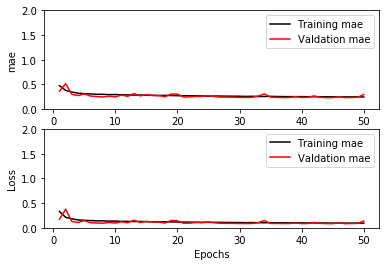

In [17]:
abs_error = abs(np.array(model.predict(x_test).flatten()- t_test))
ave_abs = np.average(abs_error)
std_abs = np.std(abs_error)
print(ave_abs, std_abs)

N = 1000
#損失関数とmaeの推移
savename = "dnc_noise%d_N%d.png" % (NOISE, N)
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(mae) + 1)

plt.subplot(2,1,1)
plt.plot(epochs, mae,  color="black", label = 'Training mae')
plt.plot(epochs, val_mae,  color="red", label = 'Valdation mae')
plt.legend()             # 凡例
plt.xlabel('Epochs')          # 軸ラベル
plt.ylabel('mae')
plt.ylim(0.0, 2.0)      # y軸の表示範囲
plt.subplot(2,1,2)
plt.plot(epochs, loss,  color="black", label = 'Training mae')
plt.plot(epochs, val_loss,  color="red", label = 'Valdation mae')
plt.legend()             # 凡例
plt.xlabel('Epochs')          # 軸ラベル
plt.ylabel('Loss')
plt.ylim(0.0, 2.0)
plt.savefig(savename) # png画像として出力
plt.show()
plt.close()

In [6]:
#CNNの実装
batch_size = 200  # 訓練データを200ずつのデータに分けて学習させる
epochs = 50 # 訓練データを繰り返し学習させる数

#データ形式の変更(シーケンス長, パラメータ数)
train_x = x_train.reshape(-1, 100, 1)
train_t = t_train.reshape(-1, 1, 1)
test_x = x_test.reshape(-1, 100, 1)
test_t = t_test.reshape(-1, 1, 1)

model = Sequential()
model.add(Conv1D(50, 3, padding='same', input_shape=(100, 1), activation='relu'))
model.add(MaxPooling1D(2, padding='same'))
model.add(Conv1D(50, 3, padding='same', activation='relu'))
model.add(MaxPooling1D(5, padding='same'))
model.add(Dropout(0.2))
model.add(Conv1D(10, 3, padding='same', activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(MaxPooling1D(5, padding='same'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(2, padding='same'))
model.add(Conv1D(1, 1, padding='same', activation='relu'))

model.summary()

model.compile(loss='mse',
 optimizer='adam',
 metrics=['mae'])

history = model.fit(train_x, train_t,
 batch_size=batch_size,
 epochs=epochs,
 verbose=1,
 validation_data=(test_x, test_t))

score = model.evaluate(test_x, test_t, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 100, 50)           200       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 50)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 50)            7550      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 10, 50)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 50)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 10, 10)            1510      
_________________________________________________________________
dense_4 (Dense)              (None, 10, 10)          

10000/10000 [==============================] - 11s 1ms/step - loss: 0.1049 - mae: 0.2620 - val_loss: 0.1115 - val_mae: 0.2728
Epoch 46/50
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1053 - mae: 0.2618 - val_loss: 0.1099 - val_mae: 0.2692
Epoch 47/50
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1030 - mae: 0.2587 - val_loss: 0.1109 - val_mae: 0.2733
Epoch 48/50
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1050 - mae: 0.2615 - val_loss: 0.1062 - val_mae: 0.2654
Epoch 49/50
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1041 - mae: 0.2606 - val_loss: 0.1117 - val_mae: 0.2737
Epoch 50/50
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1040 - mae: 0.2603 - val_loss: 0.1214 - val_mae: 0.2829
Test loss: 0.12141397394239903
Test accuracy: 0.2829241454601288


In [7]:
print(train_x.shape)
print(train_t.shape)
print(test_x.shape)
print(test_t.shape)

(10000, 100, 1)
(10000, 1, 1)
(1000, 100, 1)
(1000, 1, 1)


In [8]:
#modelの保存
save_model_path = "/Users/nagaiyuma/Desktop/maindata/201012/model_1.h5"
model.save(save_model_path)

In [9]:
#　テストデータ取得
file_num = 20 #テストファイル数20
test_num = 1000 #データ数

t_20 = np.zeros((file_num ,test_num))
x_20 = np.zeros((file_num, test_num, data_size))
n = range(0, file_num)
test_nums = range(0, test_num)

def _testdata(x, t):
    for k in n:
        
        for key in test_nums:
            file_path = "/Users/nagaiyuma/Desktop/test/" + str(n[k]) + "/x_" + str(test_nums[key]) + ".txt"
            with open(file_path) as f:
                file_str = f.read().splitlines()
                f.close

            for i in range(0, data_size):
                x[k][key][i] = float(file_str[i])

        for key in test_nums:
            file_path = "/Users/nagaiyuma/Desktop/test/" + str(n[k]) + "/t_" + str(test_nums[key]) + ".txt"
            with open(file_path) as f:
                file_str = f.read()
                f.close

            t[k][key] = float(file_str)

    return x, t


_testdata(x_20, t_20)

print(x_20.shape)
print(t_20.shape)

(20, 1000, 100)
(20, 1000)


In [ ]:
#学習パラメータの取得
from keras.models import load_model
pred_x = np.zeros((file_num ,test_num))
model = load_model(save_model_path)

for k in n:
    xtest = x_20[k].reshape(-1, 100, 1)
    pred_x[k] = model.predict(xtest).flatten()

save_predict = "/Users/nagaiyuma/Desktop/maindata/201011/t_predict.csv"
save_test = "/Users/nagaiyuma/Desktop/maindata/201011/t_test.csv"

#結果の保存
with open(save_predict,'w') as f:
    writer = csv.writer(f)
    writer.writerow(pred_x)
with open(save_test,'w') as f:
    writer = csv.writer(f)
    writer.writerow(t_20)

print(pred_x.shape)
print(t_20.shape)
abs_error = abs(pred_x - t_20)

ave = np.average(abs_error ,axis=1)
ave_20 = np.average(ave)
std_20 = np.std(ave)
print('平均絶対誤差 :' ,ave_20)
print('標準偏差 :' ,std_20)

In [ ]:
#学習パラメータの取得
pred_x = np.zeros((file_num ,test_num))
model = load_model(save_model_path)

for k in n:
    xtest = x_20[k].reshape(-1, 100, 1)
    pred_x[k] = model.predict(xtest).flatten()
    abs_error = abs(pred_x[k] - t_20[k])

save_predict = "/Users/nagaiyuma/Desktop/maindata/201012/pred_x.csv"
save_test = "/Users/nagaiyuma/Desktop/maindata/201012/t_20.csv"

#結果の保存
with open(save_predict,'w') as f:
    writer = csv.writer(f)
    writer.writerow(pred_x)
with open(save_test,'w') as f:
    writer = csv.writer(f)
    writer.writerow(t_20)

print(pred_x.shape)
print(t_20.shape)
print(abs_error.shape)

ave_20 = np.average(ave)
std_20 = np.std(ave)
print('平均絶対誤差 :' ,ave_20)
print('標準偏差 :' ,std_20)

0.28292414463907484 0.20339101449480437


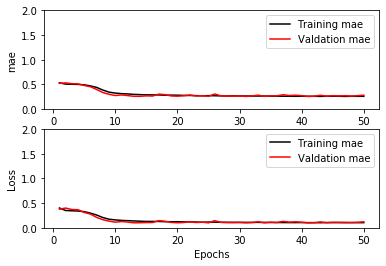

In [14]:
abs_error = abs(np.array(model.predict(test_x).flatten()- t_test))
ave_abs = np.average(abs_error)
std_abs = np.std(abs_error)
print(ave_abs, std_abs)

#損失関数とmaeの推移
savename = "cnn_noise%d_N%d_1.png" % (NOISE, N)
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(mae) + 1)

plt.subplot(2,1,1)
plt.plot(epochs, mae,  color="black", label = 'Training mae')
plt.plot(epochs, val_mae,  color="red", label = 'Valdation mae')
plt.legend()             # 凡例
plt.xlabel('Epochs')          # 軸ラベル
plt.ylabel('mae')
plt.ylim(0.0, 2.0)      # y軸の表示範囲
plt.subplot(2,1,2)
plt.plot(epochs, loss,  color="black", label = 'Training mae')
plt.plot(epochs, val_loss,  color="red", label = 'Valdation mae')
plt.legend()             # 凡例
plt.xlabel('Epochs')          # 軸ラベル
plt.ylabel('Loss')
plt.ylim(0.0, 2.0)
plt.savefig(savename) # png画像として出力
plt.show()
plt.close()

In [19]:
batch_size = 200  # 訓練データを200ずつのデータに分けて学習させる
epochs = 50 # 訓練データを繰り返し学習させる数

#データ形式の変更(シーケンス長, パラメータ数)
train_x = x_train.reshape(-1, 100, 1)
train_t = t_train
test_x = x_test.reshape(-1, 100, 1)
test_t = t_test

model = Sequential()
model.add(Conv1D(50, 3, padding='same', input_shape=(100, 1), activation='relu', kernel_initializer="he_normal"))
model.add(MaxPooling1D(2, padding='same'))
model.add(Conv1D(50, 3, padding='same', activation='relu', kernel_initializer="he_normal"))
model.add(MaxPooling1D(5, padding='same'))
model.add(Conv1D(10, 3, padding='same', activation='relu', kernel_initializer="he_normal"))
model.add(layers.Flatten())
model.add(Dense(100, activation='relu', kernel_initializer="he_normal"))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu', kernel_initializer="he_normal"))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu', kernel_initializer="he_normal"))

model.summary()

model.compile(loss='mse',
 optimizer='adam',
 metrics=['mae'])

history = model.fit(train_x, train_t,
 batch_size=batch_size,
 epochs=epochs,
 verbose=1,
 validation_data=(test_x, test_t))

score = model.evaluate(test_x, test_t, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 100, 50)           200       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 50, 50)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 50, 50)            7550      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 10, 50)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 10, 10)            1510      
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)              

Epoch 47/50
10000/10000 [==============================] - 11s 1ms/step - loss: 0.0898 - mae: 0.2451 - val_loss: 0.0786 - val_mae: 0.2241
Epoch 48/50
10000/10000 [==============================] - 10s 1ms/step - loss: 0.0878 - mae: 0.2429 - val_loss: 0.0772 - val_mae: 0.2234
Epoch 49/50
10000/10000 [==============================] - 10s 1ms/step - loss: 0.0886 - mae: 0.2460 - val_loss: 0.0805 - val_mae: 0.2290
Epoch 50/50
10000/10000 [==============================] - 12s 1ms/step - loss: 0.0871 - mae: 0.2419 - val_loss: 0.0788 - val_mae: 0.2254
Test loss: 0.07880062082409858
Test accuracy: 0.22538016736507416


In [20]:
#modelの保存
save_model_path = "/Users/nagaiyuma/Desktop/maindata/201012/model_cnn2_1.h5"
model.save(save_model_path)

0.22538016086816787 0.16734517283916187


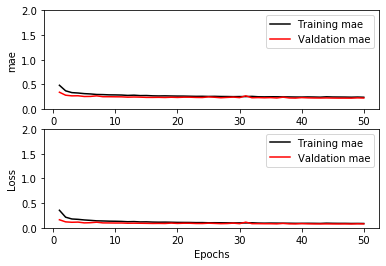

In [21]:
abs_error = abs(np.array(model.predict(test_x).flatten()- t_test))
ave_abs = np.average(abs_error)
std_abs = np.std(abs_error)
print(ave_abs, std_abs)

#損失関数とmaeの推移
savename = "cnn2_noise%d_N%d_1.png" % (NOISE, N)
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(mae) + 1)

plt.subplot(2,1,1)
plt.plot(epochs, mae,  color="black", label = 'Training mae')
plt.plot(epochs, val_mae,  color="red", label = 'Valdation mae')
plt.legend()             # 凡例
plt.xlabel('Epochs')          # 軸ラベル
plt.ylabel('mae')
plt.ylim(0.0, 2.0)      # y軸の表示範囲
plt.subplot(2,1,2)
plt.plot(epochs, loss,  color="black", label = 'Training mae')
plt.plot(epochs, val_loss,  color="red", label = 'Valdation mae')
plt.legend()             # 凡例
plt.xlabel('Epochs')          # 軸ラベル
plt.ylabel('Loss')
plt.ylim(0.0, 2.0)
plt.savefig(savename) # png画像として出力
plt.show()
plt.close()

In [22]:
#訓練データ,テストデータの保存
save_x_train = "/Users/nagaiyuma/Desktop/maindata/x_train.csv"
save_t_train = "/Users/nagaiyuma/Desktop/maindata/t_train.csv"
save_x_test = "/Users/nagaiyuma/Desktop/maindata/x_test.csv"
save_t_test = "/Users/nagaiyuma/Desktop/maindata/t_test.csv"

with open(save_x_train,'w') as f:
    writer = csv.writer(f)
    writer.writerows(x_train)
with open(save_t_train,'w') as f:
    writer = csv.writer(f)
    writer.writerow(t_train)
with open(save_x_test,'w') as f:
    writer = csv.writer(f)
    writer.writerows(x_test)
with open(save_t_test,'w') as f:
    writer = csv.writer(f)
    writer.writerow(t_test)